In [1]:
import h5py
import matplotlib
import matplotlib.pyplot as plt
import os
import glob
import mdtraj as md
import numpy as np
from tqdm import tqdm
from westpa_helpers import *

In [2]:
FPS=10 # FPS for movie
protein_name = "chignolin"
all_native_file_strided_file = "/media/DATA_18_TB_1/andy/benchmark_cache/chignolin_native_trajs_CG_stride100_nrNativePaths373_300K.pkl"
num_bins = 80


In [3]:
# Change this to the root of the run
home_path=f"/media/DATA_18_TB_1/awaghili/WESTPA_MM/mabbin_{protein_name}/westpa_prop"
os.chdir(home_path)

sim_config = extract_all_atom_simulation_config()


# Will be needed to unpickle the TICA models
import sys
sys.path.append(sim_config['cgschnet_path'])

In [5]:
topology = mdtraj.load(sim_config['topology_path']).topology
traj_dirs = sorted(glob.glob(f"./traj_segs/*/*"))
ca_indices = [atom.index for atom in topology.atoms if atom.name == 'CA']


trajectories = []
for td in tqdm(traj_dirs):
    dcd_path = os.path.join(td, "seg.dcd")
    if not os.path.isfile(dcd_path):
        print(f"Missing file: {dcd_path}")
        continue
    try:
        traj = mdtraj.load(dcd_path, top=topology)
        traj_ca = traj.atom_slice(ca_indices)
        trajectories.append(traj_ca)
    except Exception as e:
        print(f"Error loading {dcd_path}")
        print(e)
        continue

100%|██████████| 3859/3859 [00:05<00:00, 650.92it/s]


In [6]:
from report_generator.tica_plots import calc_atom_distance

tica_model = load_tica_model(sim_config["tica_model_path"])

with open(all_native_file_strided_file, 'rb') as all_native_file_strided:
    native_trajs_strided = pickle.load(all_native_file_strided)
    
    native_proj_datas: list[np.typing.NDArray]  = tica_model.decompose([calc_atom_distance(x.trajectory) for x in tqdm(native_trajs_strided)])
    assert not np.isnan(native_proj_datas).any()
    
    strideNative = 10
    native_proj_datas_concat = np.concatenate(native_proj_datas)[::strideNative]

/home/md-ml/miniconda3/envs/andy-reports-3/lib/python3.11/site-packages/deeptime/base.py:116: UserWarning: Trying to unpickle estimator CovarianceModel from version 0.4.5 when using version 0.4.4. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/md-ml/miniconda3/envs/andy-reports-3/lib/python3.11/site-packages/deeptime/base.py:116: UserWarning: Trying to unpickle estimator CovarianceKoopmanModel from version 0.4.5 when using version 0.4.4. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
100%|██████████| 373/373 [00:00<00:00, 24933.47it/s]


100%|██████████| 3859/3859 [00:02<00:00, 1809.20it/s]


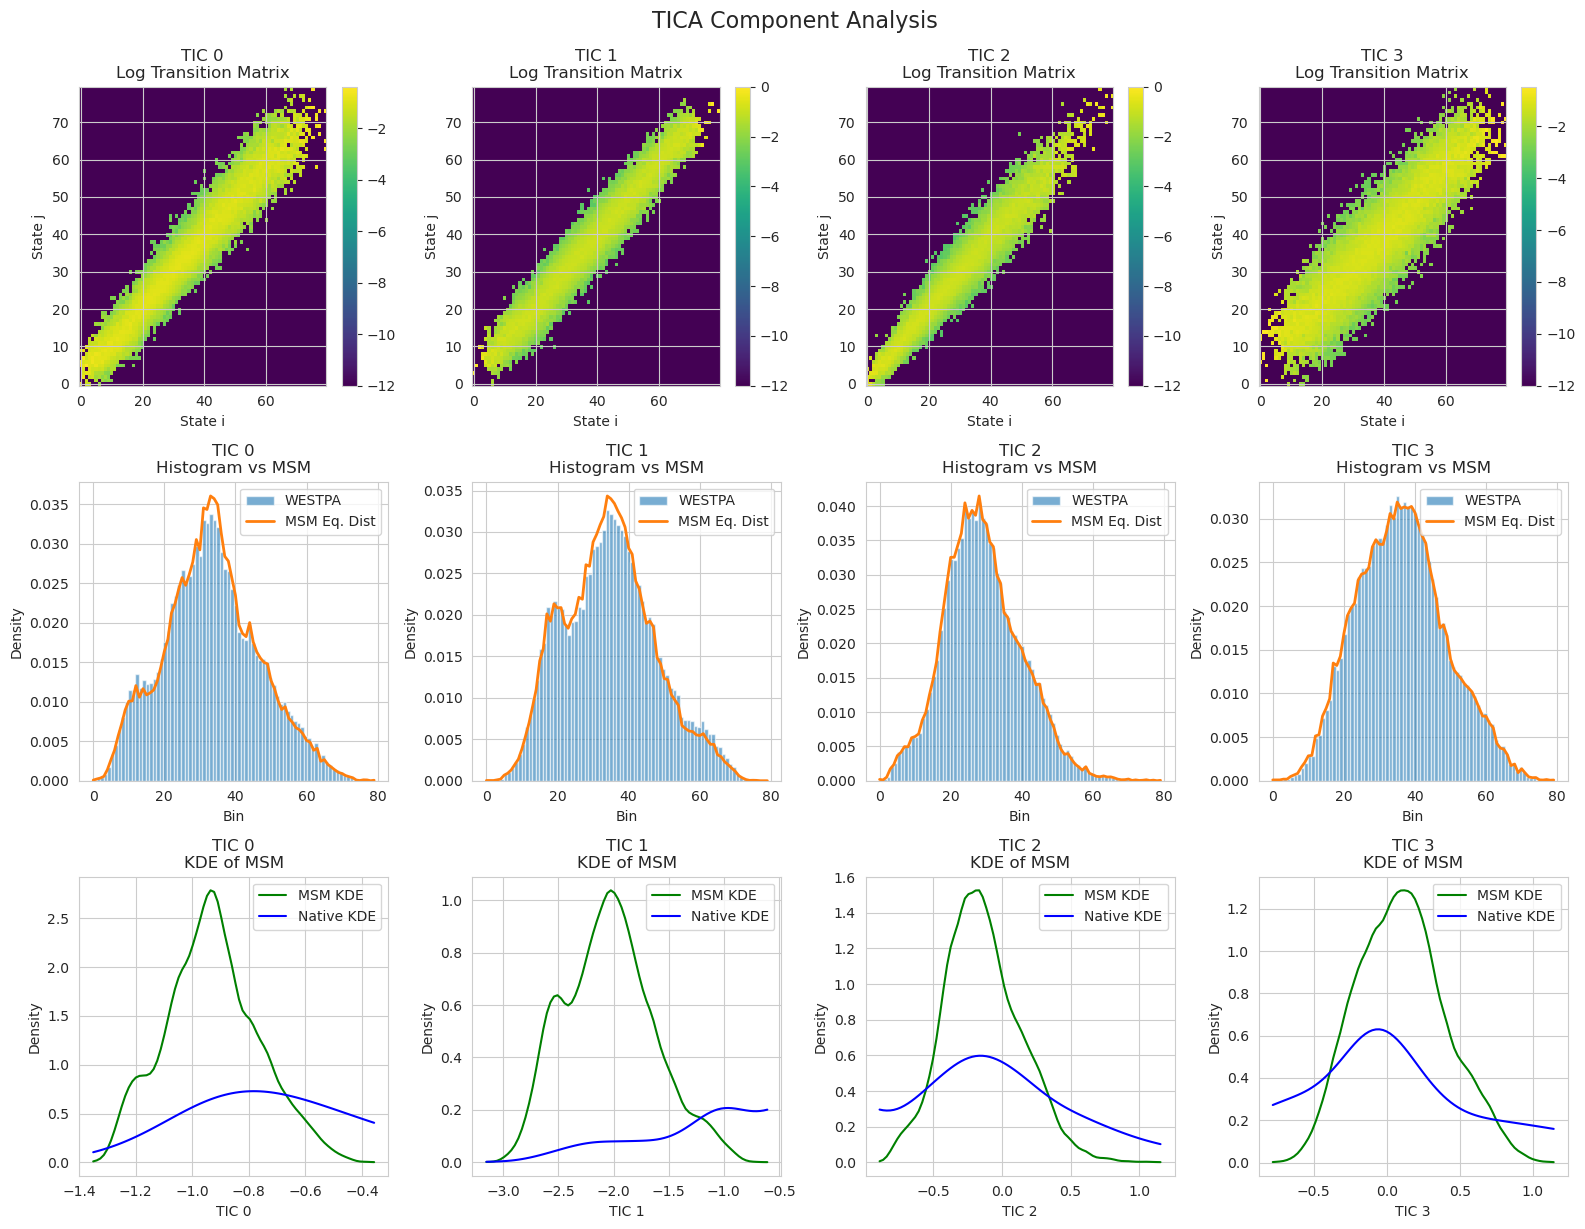

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

tica_components = [0, 1, 2, 3]

n_comps = len(tica_components)

fig, axes = plt.subplots(3, n_comps, figsize=(4 * n_comps, 12))

for i, comp in enumerate(tica_components):
    # Step 1: Calculate component values
    component_values = []
    for traj in tqdm(trajectories):
        values = calculate_component_values(tica_model, traj, [comp])
        component_series = np.array(values[comp])
        component_values.append(component_series)

    # Step 2: Bin component values
    component_min = min([min(cv) for cv in component_values])
    component_max = max([max(cv) for cv in component_values])
    component_bins = np.linspace(component_min, component_max, num_bins + 1)
    bin_centers = 0.5 * (component_bins[:-1] + component_bins[1:])

    binned_components = [
        np.clip((num_bins * (cv - component_min) / (component_max - component_min)).astype(int), None, num_bins - 1)
        for cv in component_values
    ]

    # Step 3: Build transition matrix
    transition_matrix = np.zeros((num_bins, num_bins), dtype=int)
    for binned_traj in binned_components:
        for j in range(len(binned_traj) - 1):
            transition_matrix[binned_traj[j], binned_traj[j + 1]] += 1

    # Step 4: Normalize to transition probability matrix
    transition_prob_matrix = transition_matrix.astype(np.double)
    row_sums = transition_prob_matrix.sum(axis=1, keepdims=True)
    transition_prob_matrix = np.divide(
        transition_prob_matrix, row_sums, out=np.zeros_like(transition_prob_matrix), where=row_sums != 0
    )

    # Step 5: Stationary distribution
    eigenvalues, eigenvectors = np.linalg.eig(transition_prob_matrix.T)
    stationary_vector = eigenvectors[:, np.isclose(eigenvalues, 1)]

    if stationary_vector.shape[1] != 1:
        raise ValueError(f"Stationary distribution for component {comp} is not unique")

    stationary_distribution = stationary_vector / np.sum(stationary_vector)
    stationary_distribution = stationary_distribution.real.flatten()

    # --- Plot 1: Log Transition Matrix ---
    ax0 = axes[0, i]
    im0 = ax0.imshow(np.log10(transition_prob_matrix.T + 1e-12), origin='lower', aspect='auto', cmap='viridis')
    ax0.set_title(f'TIC {comp}\nLog Transition Matrix')
    ax0.set_xlabel('State i')
    ax0.set_ylabel('State j')
    fig.colorbar(im0, ax=ax0, orientation='vertical')

    # --- Plot 2: Histogram + MSM stationary distribution ---
    ax1 = axes[1, i]
    ax1.hist(np.concatenate(binned_components), bins=num_bins, density=True, alpha=0.6, label='WESTPA')
    ax1.plot(stationary_distribution, label='MSM Eq. Dist', linewidth=2)
    ax1.set_title(f'TIC {comp}\nHistogram vs MSM')
    ax1.set_xlabel('Bin')
    ax1.set_ylabel('Density')
    ax1.legend()

    # --- Plot 3: KDE of MSM stationary distribution ---\

    ax2 = axes[2, i]
    kde = gaussian_kde(bin_centers, weights=stationary_distribution, bw_method=0.1)
    kde_values = kde(bin_centers)
    ax2.plot(bin_centers, kde_values, label='MSM KDE', color='green')
    
    native_kde = gaussian_kde(native_proj_datas_concat[:, i].T)
    native_kde_values = native_kde(bin_centers)
    ax2.plot(bin_centers, native_kde_values, label='Native KDE', color='blue')

    ax2.set_title(f'TIC {comp}\nKDE of MSM')
    ax2.set_xlabel(f'TIC {comp}')
    ax2.set_ylabel('Density')
    ax2.legend()

# Final layout and show
plt.tight_layout()
plt.suptitle("TICA Component Analysis", y=1.02, fontsize=16)
plt.show()